In [1]:
import sys
import os
# Use autoreload for any modification updates
import airavata_cerebrum.dataset.abc_mouse as abc_mouse
import airavata_cerebrum.dataset.mouse_brain as mouse_brain
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Allen Brain Cell Atlas (ABC) Mouse Datasets

- Allen Brain Cell Atlas (ABC) Mouse Single cell datasets
    - Yao et. al. (2023) :  Two large gene expression datasets and a Spatial Gene expression dataset
    - Zhang et. al. (2023) : Three Spatial Gene expresion datasets
- Current Focus: Yao et. al. (2023)  Spatial Transcriptomics Dataset
    - ~4.0 million cells.
    - 500 gene panel MERFESH dataset.
- Dataset source:
    - 59 coronal sections (10 micron thick) covering the whole anterior to posterior extent of the brain (~200 micron apart) from a single adult male mouse. 
- With MERFISH assay, each cell also has a set of x, y, z coordinates:
    - x and y generated by rotating each section so that it is upright with midline approximately in the middle of the frame.
    - z coordinate takes into account the physical spacing between each section

# Downloading data
- ABC data is stored in AWS data strore.
- In order to download the data, AWS CLI needs to be installed.
- __download_abc_data__ function is available in the abc_mouse package to download the necessary data.
- After setting the appropriate abc_mouse.ABC_BASE variable, **Uncomment** the last line in the cell below to download the data in the ABC_BASE directory.

In [2]:
# Downloading the necessary data
ABC_ATLAS_BASE = "/storage/home/hhive1/schockalingam6/data2/neuroscience/brain_atlases/abc_mouse_atlas" # Change this to the directory to download
# abc_mouse.download_abc_data(ABC_ATLAS_BASE) # Uncomment to download data

/storage/hive/project/cse-aluru/schockalingam6/spack/opt/spack/linux-rhel7-cascadelake/gcc-10.3.0/anaconda3-2023.09-0-pkdoptdlfegubols42bj3mgd52g2tfxc/envs/envt1/lib/python3.10/site-packages/abc_atlas_access/abc_atlas_cache/cloud_cache.py:470: MissingLocalManifestWarning: This cache directory appears to contain data files, but it has no record of what those files are. Unless running as a LocalCache, files will be re-downloaded.
  warnings.warn(msg, MissingLocalManifestWarning)
parcellation.csv: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41.2k/41.2k [00:00<00:00, 119kMB/s]
parcellation_term.csv: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 177k/177k [00:00<00:00, 580kMB/s]
parcellation_term_set.csv: 100%|████████

# Structure of a single cell Gene Expression dataset

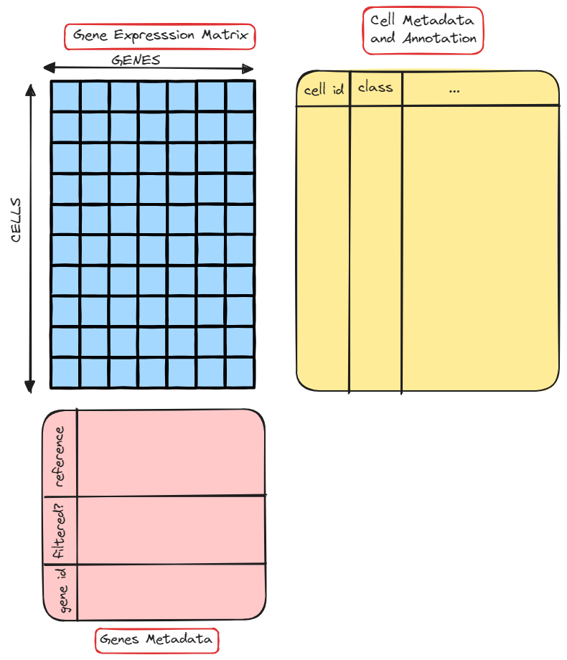

Gene expression datasets can be seen as composed of three tables :

- Gene Expression Data
- Cell meta data
   - Experiment: e.g. disease, organism, sex, donor, etc.
   - Region: e.g. layer, region, etc.
   - Stats & Analysis: e.g. ncounts, cell type, etc.
- Gene meta data
   - Avg. expression level, Is highly variable, etc.


In [3]:
# Load Cell metadata and Gene metadata 
cell_meta = abc_mouse.cell_metadata(ABC_ATLAS_BASE)
gene_meta = abc_mouse.gene_metadata(ABC_ATLAS_BASE)

## Whole Brain Taxonomy Data
The Allen Brain Cell Atlas includes an integrated transcriptomic taxonomy that contains
 - 5,322 clusters that are organized in a hierarchical manner
     - Top level of 34 classes
     - Second-level of 338 subclasses
     - Third-level of 1,201 supertypes and
     - Fourth-level of 5,322 types/clusters.

Example of classes:

     '01 IT-ET Glut',
     '02 NP-CT-L6b Glut',
     '03 OB-CR Glut',
     '04 DG-IMN Glut',
     '05 OB-IMN GABA',
     '06 CTX-CGE GABA',
     '07 CTX-MGE GABA',
     '08 CNU-MGE GABA',
     '09 CNU-LGE GABA'

### Exteneded Cell Metadata

- Load the taxonomy data for all the cells
- Extend the cell meta data to include the class, subclass and types information.


In [4]:
cluster_details, cluster_colors = abc_mouse.taxonomy_cluster(ABC_ATLAS_BASE)
cell_meta_ext = cell_meta.join(cluster_details, on="cluster_alias")
cell_meta_ext = cell_meta_ext.join(cluster_colors, on="cluster_alias")

## Allen Mouse CCF co-ordinates and parcellation
- Dataset source:
    - 59 coronal sections (10 micron thick) covering the whole anterior to posterior extent of the brain (~200 micron apart) from a single adult male mouse. 
- As mentioned in a MERFISH dataset, each cell also has a set of x, y, z coordinates.
- Allen Mouse Brain Common Coordinate Framework (CCFv3, Wang et al, 2020) is a 3D reference space of an average brain at 10um voxel resolution.
- Each section from the whole brain MERFISH dataset is mapped Allen CCFv3.
- Parcellaton division, structure and substructure are derived from the co-ordinates mapped to Allen CCF.

In [5]:
# Loading CCF Meta data
ccf_meta_file = abc_mouse.abc_cache_download_meta(ABC_ATLAS_BASE, abc_mouse.MERFISH_CCF_DATASET_KEY, abc_mouse.PARCEL_META_DATA_KEY)
cell_ccf = abc_mouse.cell_ccf_meta(ccf_meta_file)
cell_ccf

,cell_label,brain_section_label,cluster_alias,average_correlation_score,feature_matrix_label,donor_label,donor_genotype,donor_sex,x_section,y_section,...,parcellation_organ,parcellation_category,parcellation_division,parcellation_structure,parcellation_substructure,parcellation_organ_color,parcellation_category_color,parcellation_division_color,parcellation_structure_color,parcellation_substructure_color
0,1019171907102340387-1,C57BL6J-638850.37,1408,0.596276,C57BL6J-638850,C57BL6J-638850,wt/wt,M,7.226245,4.148963,...,brain,grey,HPF,DG,DG-po,#FFFFFF,#BFDAE3,#7ED04B,#7ED04B,#7ED04B
1,1104095349101460194-1,C57BL6J-638850.26,4218,0.641180,C57BL6J-638850,C57BL6J-638850,wt/wt,M,5.064889,7.309543,...,brain,grey,P,TRN,TRN,#FFFFFF,#BFDAE3,#FF9B88,#FFBA86,#FFBA86
2,1017092617101450577,C57BL6J-638850.25,4218,0.763531,C57BL6J-638850,C57BL6J-638850,wt/wt,M,5.792921,8.189973,...,brain,grey,P,P-unassigned,P-unassigned,#FFFFFF,#BFDAE3,#FF9B88,#FF9B88,#FF9B88
3,1018093344101130233,C57BL6J-638850.13,4218,0.558073,C57BL6J-638850,C57BL6J-638850,wt/wt,M,3.195950,5.868655,...,brain,fiber tracts,cbf,arb,arb,#FFFFFF,#CCCCCC,#CCCCCC,#CCCCCC,#CCCCCC
4,1019171912201610094,C57BL6J-638850.27,4218,0.591009,C57BL6J-638850,C57BL6J-638850,wt/wt,M,5.635732,7.995842,...,brain,grey,P,P-unassigned,P-unassigned,#FFFFFF,#BFDAE3,#FF9B88,#FF9B88,#FF9B88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3739956,1018093344100380167-3,C57BL6J-638850.47,5252,0.574988,C57BL6J-638850,C57BL6J-638850,wt/wt,M,1.560003,4.669243,...,brain,grey,Isocortex,SSp-n,SSp-n2/3,#FFFFFF,#BFDAE3,#70FF71,#188064,#188064
3739957,1017165415100930567,C57BL6J-638850.57,5254,0.620546,C57BL6J-638850,C57BL6J-638850,wt/wt,M,5.032556,3.695696,...,brain,grey,Isocortex,ACAd,ACAd5,#FFFFFF,#BFDAE3,#70FF71,#40A666,#40A666
3739958,1017155956102610748,C57BL6J-638850.49,5254,0.548053,C57BL6J-638850,C57BL6J-638850,wt/wt,M,2.549142,4.231188,...,brain,grey,Isocortex,SSp-m,SSp-m6a,#FFFFFF,#BFDAE3,#70FF71,#188064,#188064
3739959,1017155956101980080-1,C57BL6J-638850.50,5252,0.621901,C57BL6J-638850,C57BL6J-638850,wt/wt,M,1.381324,5.784595,...,brain,grey,Isocortex,SSs,SSs1,#FFFFFF,#BFDAE3,#70FF71,#188064,#188064


## Region Specific Ratios
- Inhibitory types are : 'Vip', 'Pvalb', 'SSt', 'Lamp5', 'Sst-Chodl', 'GABA-Other' (Inhibitory cells that are not one of Vip, Pvalb, SSt, SST-Chodl)
- Exitatory types are :  "IT", "ET", "CT", "NP", "Glut-Other"(Excitatory cells that are not one of IT, ET, CT or NP)
- IT types are further classified as "IT-CTX","IT-ENT" and "IT-Other"
- Based on the parcelletion information of the Allen CCF to find the layer specific ratios using _region_ccf_cell_types_ function
- First, we get data frame with flags set indicating the cell types and cell sub-types from the meta data
- Next, we group by the layers in sub-region to obtain summary statistics
- Finally, we compute the ratios in each layer 
- The above three steps is computed for each layer and merge all the data

In [6]:
# Obtain Region Specific CCF
region_cell_ccf, region_ei_ccf, region_frac_ccf = abc_mouse.region_ccf_cell_types(cell_ccf, ["MOp", "MOs", "AUDp", "AUDd", "VISp", "VISl"])
# Merge the data 
cortex_fx_df = pd.concat([y for x,y in region_frac_ccf.items()])
cortex_fx_df

,Region,Layer,nregion,inhibitory fraction,fraction wi. region,Vip fraction,Pvalb fraction,Sst fraction,Lamp5 fraction,Sst-Chodl fraction,IT-ENT fraction,IT-CTX fraction,IT-Other fraction,ET fraction,CT fraction,NP fraction,IT fraction
parcellation_substructure,,,,,,,,,,,,,,,,,
MOp1,MOp,1,83976,0.573668,0.080249,0.135246,0.027322,0.049180,0.691257,0.016393,0.001838,0.992647,0.000000,0.000000,0.000000,0.000000,0.994485
MOp2/3,MOp,2/3,83976,0.133317,0.402222,0.225015,0.366033,0.217045,0.146229,0.006744,0.002216,0.993021,0.000000,0.002122,0.000047,0.002499,0.995237
MOp5,MOp,5,83976,0.157700,0.230447,0.065739,0.436660,0.412188,0.049904,0.014395,0.012847,0.603450,0.000090,0.240589,0.058755,0.081574,0.616387
MOp6a,MOp,6a,83976,0.096594,0.260574,0.045137,0.401144,0.366815,0.095995,0.027972,0.000679,0.259901,0.009986,0.030297,0.606684,0.024591,0.270566
MOp6b,MOp,6b,83976,0.055712,0.026508,0.063291,0.189873,0.215190,0.177215,0.113924,0.000000,0.057506,0.020911,0.000000,0.174757,0.000000,0.078417
MOs1,MOs,1,90859,0.507225,0.113373,0.150295,0.045187,0.051081,0.647348,0.006876,0.000000,0.995956,0.000000,0.001011,0.000000,0.000000,0.995956
MOs2/3,MOs,2/3,90859,0.137799,0.420311,0.252832,0.351442,0.221936,0.125386,0.005149,0.006008,0.984610,0.001234,0.004732,0.000082,0.003333,0.991853
MOs5,MOs,5,90859,0.173107,0.237489,0.061767,0.471853,0.387021,0.055121,0.008991,0.009002,0.572551,0.000000,0.225550,0.072674,0.119568,0.581553
MOs6a,MOs,6a,90859,0.103030,0.220231,0.068289,0.403651,0.345504,0.082488,0.020284,0.003107,0.224837,0.005048,0.055297,0.614477,0.028347,0.232992


## Ratio data
- Ratio data is made available as a data frame with the columns indicating the fractions
- Key columns are
    1. 'fraction wi. region' : Fraction of cells in this layer within this region
    2. 'inhibitory fraction' : Fraction of cells that re inhibitory
    3. 'Vip fraction' : Among the inhibitory cells, fraction of Vip cells
    4. 'Lamp5 fraction' : Among the inhibitory cells, fraction of Lamp5 cells
    5. 'Sst-Chodl fraction' : Among the inhibitory cells, fraction of Sst-Chodl cells
    6. 'GABA Other fraction' : Among the inhibitory cells, fraction of cells that is none of Vip, Lamp5, SSt, SSt-Chodl
    7. 'IT fraction': Among the excitatory cells, fraction of cells that are intratelencephalic projecting.
    8. 'ET fraction': Among the excitatory cells, fraction of cells that are extratelencephalic projecting.
    9. 'CT fraction': Among the excitatory cells, fraction of cells that are corticothalamic
    10. 'NP fraction': Among the excitatory cells, fraction of cells that are non-projecting
    11. 'Glut Other fraction': Among the excitatory cells, fraction of cells that are not one of IT, ET, CT or NP
    12. 'IT-CTX fraction', 'IT-ENT fraction', 'IT-Other fraction' : Fraction of cells among the IT cell types

In [7]:
cortex_fx_df.loc[cortex_fx_df.Region == "VISp"]

,Region,Layer,nregion,inhibitory fraction,fraction wi. region,Vip fraction,Pvalb fraction,Sst fraction,Lamp5 fraction,Sst-Chodl fraction,IT-ENT fraction,IT-CTX fraction,IT-Other fraction,ET fraction,CT fraction,NP fraction,IT fraction
parcellation_substructure,,,,,,,,,,,,,,,,,
VISp1,VISp,1,61884,0.405155,0.069663,0.147583,0.038168,0.035623,0.720102,0.007634,0.001733,0.986135,0.001733,0.000000,0.000000,0.000000,0.989601
VISp2/3,VISp,2/3,61884,0.078755,0.348620,0.316690,0.332382,0.161912,0.158345,0.002140,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
VISp4,VISp,4,61884,0.111916,0.209699,0.131933,0.532773,0.315126,0.018487,0.000000,0.000000,0.962618,0.000000,0.029334,0.000212,0.007413,0.962618
VISp5,VISp,5,61884,0.165428,0.177606,0.021739,0.487681,0.455797,0.022464,0.006522,0.001867,0.519247,0.000144,0.323039,0.043953,0.104137,0.521258
VISp6a,VISp,6a,61884,0.062779,0.163661,0.038321,0.562044,0.348540,0.025547,0.010949,0.001711,0.212443,0.001834,0.000611,0.759320,0.005378,0.215988
VISp6b,VISp,6b,61884,0.052910,0.030751,0.037500,0.475000,0.275000,0.087500,0.075000,0.000000,0.042598,0.004190,0.000000,0.725559,0.000000,0.046788


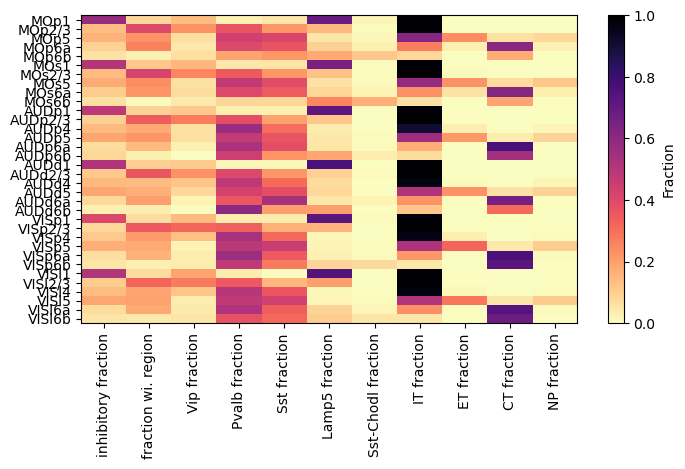

In [14]:
fraction_cols = ['inhibitory fraction', 'fraction wi. region', 'Vip fraction',
                 'Pvalb fraction', 'Sst fraction', 'Lamp5 fraction',
                 'Sst-Chodl fraction','IT fraction', 'ET fraction',
                 'CT fraction', 'NP fraction']

abc_mouse.plot_heatmap(cortex_fx_df[fraction_cols], ylabel="Fraction", lmin=0, lmax=1)